#Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Importing Data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data/ab_data.csv',
                   parse_dates = ['timestamp'],
                   dtype = {'user_id': 'str', 'converted':'bool'})
df = data.copy()

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,False
1,804228,2017-01-12 08:01:45.159739,control,old_page,False
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,False
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,False
4,864975,2017-01-21 01:52:26.210827,control,old_page,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  object        
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  bool          
dtypes: bool(1), datetime64[ns](1), object(3)
memory usage: 9.3+ MB


#Data Cleaning

##Cleaning missing values

In [ ]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

There's no missing value.

##Cleaning duplicates

In [ ]:
df.duplicated().sum()

0

There's no duplicate data

##User assignment validation

We have to make sure there is no user who's assigned in more than 1 group or wrong group. If the users are assigned in control group, they must see old page (landing page). If the users are assigned in treatment group they must see new page.

In [ ]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


There are 1928 users in control group who saw new page (landing page) and 1965 users in treatment group who saw old page. We have to check if they are assigned in both groups or not.

In [ ]:
df_user = df.groupby('user_id', as_index=False)['group'].value_counts()
df_user

,user_id,group,count
0,630000,treatment,1
1,630001,treatment,1
2,630002,control,1
3,630003,treatment,1
4,630004,treatment,1
...,...,...,...
292474,945994,control,1
292475,945996,treatment,1
292476,945997,control,1
292477,945998,control,1


In [ ]:
#Checking if any users who are assigned in both groups
df_duplicate = df_user[df_user.duplicated(subset=['user_id'], keep=False)]
df_duplicate

,user_id,group,count
281,630320,treatment,1
282,630320,control,1
727,630805,treatment,1
728,630805,control,1
789,630871,control,1
...,...,...,...
291903,945369,control,1
291918,945387,treatment,1
291919,945387,control,1
292138,945627,control,1


We have to drop them from this experiment

In [ ]:
#Getting the list of user_id who's assigned in both group
wrong_user = list(df_duplicate['user_id'].unique())

#Dropping them
df_cleaned1 = df[~ df['user_id'].isin(wrong_user)]

#Checking the result
pd.crosstab(df_cleaned1['group'], df_cleaned1['landing_page'])

landing_page,new_page,old_page
group,,
control,1007,144300
treatment,144390,991


There are still users in control group who saw new page (landing page), and vice versa. We need to exclude them.

In [ ]:
df_cleaned2 = df_cleaned1[((df_cleaned1['group']=='control') & (df_cleaned1['landing_page']=='old_page')) | \
                          ((df_cleaned1['group']=='treatment') & (df_cleaned1['landing_page']=='new_page'))]

pd.crosstab(df_cleaned2['group'], df_cleaned2['landing_page'])

landing_page,new_page,old_page
group,,
control,0,144300
treatment,144390,0


Now, all users are correctly assigned.

In [ ]:
df_cleaned2

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,False
1,804228,2017-01-12 08:01:45.159739,control,old_page,False
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,False
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,False
4,864975,2017-01-21 01:52:26.210827,control,old_page,True
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,False
294474,945152,2017-01-12 00:51:57.078372,control,old_page,False
294475,734608,2017-01-22 11:45:03.439544,control,old_page,False
294476,697314,2017-01-15 01:20:28.957438,control,old_page,False


#Experimental Design

##Minimum sample size

In [ ]:
#Calculating the baseline of conversion rate from control group
conv_rate_control = df_cleaned2[df_cleaned2['group']=='control']['converted'].mean()
conv_rate_control

0.12030492030492031

The goal of creating new design of landing page is to increase conversion rate 3% (from 12% to 15%)

In [ ]:
#Specifying the minimum target of conversion rate
conv_rate_new = 0.15

In [ ]:
#Calculating standardized effect size
from statsmodels.stats.proportion import proportion_effectsize
std_effect_size = proportion_effectsize(conv_rate_new, conv_rate_control)
std_effect_size

0.08697780511967357

In [ ]:
#Import power module
from statsmodels.stats import power

#Estimating sample size
sample_size = power.TTestIndPower().solve_power(effect_size=std_effect_size,
                                                power=0.80,
                                                alpha=0.05,
                                                nobs1=None)
sample_size

2075.968558513573

We need minimum sample size 2076 for each group.

In [ ]:
df_cleaned2['group'].value_counts()

treatment    144390
control      144300
Name: group, dtype: int64

The sample we have for each group has met the minimum sample size.

#Exploratory Data Analysis (EDA)

##Summary statistics

###The start and end time of observation

In [ ]:
#Checking the start and end time of observation
df_cleaned2['timestamp'].agg(['min', 'max'])

min   2017-01-02 13:42:05.378582
max   2017-01-24 13:41:54.460509
Name: timestamp, dtype: datetime64[ns]

The observations were conducted in 3 weeks.

###Number of observations per group

In [ ]:
#Calculating number of observations per group
df_cleaned2['group'].value_counts()

treatment    144390
control      144300
Name: group, dtype: int64

Treatment group has slightly higher number of observations than control group.

In [ ]:
#Calculating percentage of number of observations per group
df_cleaned2['group'].value_counts(normalize=True)

treatment    0.500156
control      0.499844
Name: group, dtype: float64

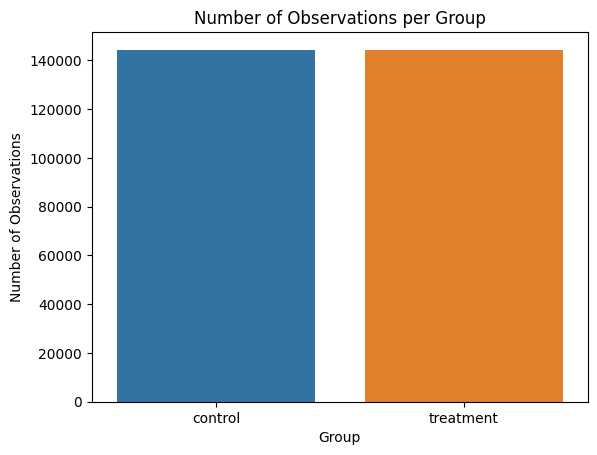

In [ ]:
sns.countplot(data=df_cleaned2,
              x='group',
              hue='group')
plt.title('Number of Observations per Group')
plt.xlabel('Group')
plt.ylabel('Number of Observations')
plt.show()

###Number of user per group

In [ ]:
user_group = df_cleaned2.groupby('group', as_index=False)['user_id'].nunique()
user_group

,group,user_id
0,control,144300
1,treatment,144389


Treatment group has slightly higher number of users than control group.

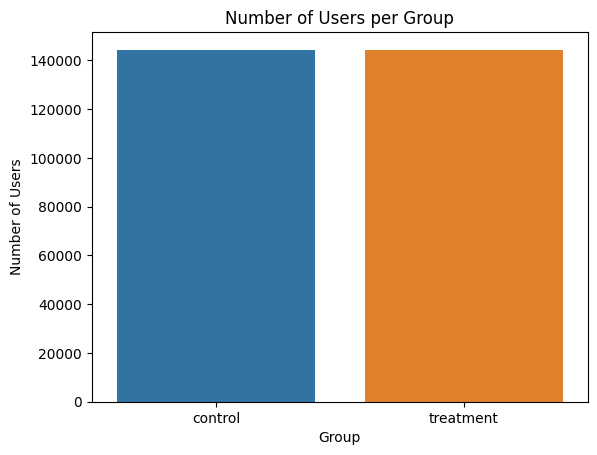

In [ ]:
sns.barplot(data=user_group,
            x='group',
            y='user_id',
            hue='group',
            errorbar=None)
plt.title('Number of Users per Group')
plt.xlabel('Group')
plt.ylabel('Number of Users')
plt.show()

###Number of converted users per group

In [ ]:
conv_user_group = df_cleaned2[df_cleaned2['converted']==True].groupby('group', as_index=False)['user_id'].nunique()
conv_user_group

,group,user_id
0,control,17360
1,treatment,17158


Control group has slightly higher number of converted users than treatment group.

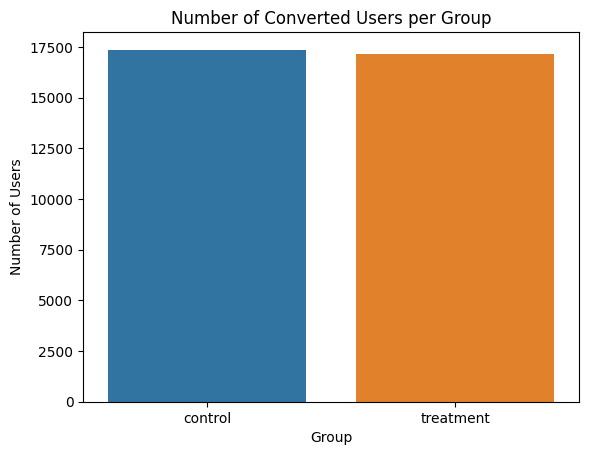

In [ ]:
sns.barplot(data=conv_user_group,
            x='group',
            y='user_id',
            hue='group',
            errorbar=None)
plt.title('Number of Converted Users per Group')
plt.xlabel('Group')
plt.ylabel('Number of Users')
plt.show()

###Conversion rate per group

In [ ]:
#Calculating conversion rate per group
df_cleaned2.groupby('group', as_index=False)['converted'].mean()

,group,converted
0,control,0.120305
1,treatment,0.118831


Control group has slightly higher conversion rate than treatment group.

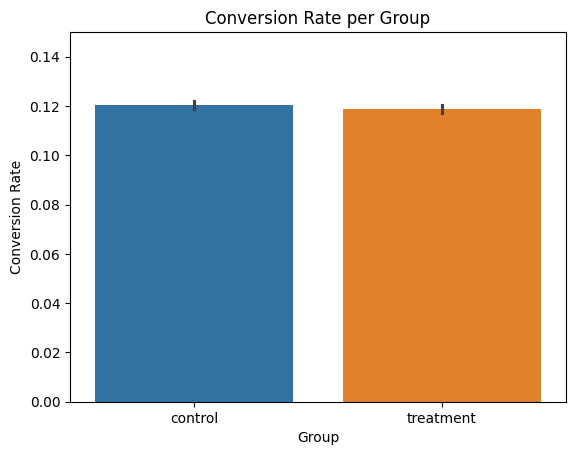

In [ ]:
sns.barplot(data=df_cleaned2,
            x='group',
            y='converted',
            estimator='mean',
            hue='group')
plt.title('Conversion Rate per Group')
plt.xlabel('Group')
plt.ylabel('Conversion Rate')
plt.ylim([0, 0.15])
plt.show()

#Sanity Check

##Sample Ratio Mismatch (SRM)

When we design an experiment to allocate enrollment units (e.g. users) at a given percentage per variant, we expect some slight variations to happen due to logging issues, delays, minor instrumentation bugs, etc. When that deviation is larger than what is expected, however, this is usually an indication of a larger issue that could invalidate and bias our test results. Now, We would like to examine the statistical techniques that enable us to catch cases where the allocation mismatch is too large to be blamed on chance alone.

In [ ]:
# Assign the unique counts to each variant
control_users = df_cleaned2[df_cleaned2['group'] == 'control']['user_id'].nunique()
treatment_users = df_cleaned2[df_cleaned2['group'] == 'treatment']['user_id'].nunique()
total_users = control_users + treatment_users
print("Control group unique users:",control_users)
print("Treatment group unique users:",treatment_users)


# Calculate the percentages and create two lists
control_perc = control_users / total_users
treatment_perc = treatment_users / total_users
print("Percentage of users in the Control group:",100*round(control_perc,4),"%")
print("Percentage of users in the Treatment group:",100*round(treatment_perc,4),"%")


observed = [ control_users, treatment_users ]
expected = [ total_users/2, total_users/2 ]


# Run chisquare test on observed and expected lists and print the results
from scipy.stats import chisquare
chi = chisquare(observed, f_exp=expected)


print(chi)
if chi[1] < 0.05:
    print("SRM may be present")
else:
    print("SRM likely not present")

Control group unique users: 144300
Treatment group unique users: 144389
Percentage of users in the Control group: 49.980000000000004 %
Percentage of users in the Treatment group: 50.019999999999996 %
Power_divergenceResult(statistic=0.027437831022311208, pvalue=0.8684373649715974)
SRM likely not present


The difference of number of users between control and treatment groups is not statistically significant.

#Hypothesis Testing

H0: There is no difference between conversion rate of control and treatment groups  

HA: There is statistically significant difference between conversion rate of control and treatment groups

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Calculate the number of users in groups Control and Treatment
n_control = df_cleaned2[df_cleaned2['group'] == 'control']['user_id'].nunique()
n_treatment = df_cleaned2[df_cleaned2['group'] == 'treatment']['user_id'].nunique()
print('Control Group users:',n_control)
print('Treatment Group users:',n_treatment, '\n')


# Compute unique converted users in each group and assign to lists
converted_control = df_cleaned2[df_cleaned2['group'] == 'control'].groupby('user_id')['converted'].max().sum()
converted_treatment = df_cleaned2[df_cleaned2['group'] == 'treatment'].groupby('user_id')['converted'].max().sum()


converted_abtest = [converted_control, converted_treatment]
n_abtest = [n_control, n_treatment]


# Calculate the z_stat, p-value, and 95% confidence intervals
z_stat, pvalue = proportions_ztest(converted_abtest, nobs=n_abtest)
(A_lo95, B_lo95), (A_up95, B_up95) = proportion_confint(converted_abtest, nobs=n_abtest, alpha=0.05)


print(f'p-value: {pvalue:.4f}')
print(f'Control Group 95% CI : [{A_lo95:.4f}, {A_up95:.4f}]')
print(f'Treatment Group 95% CI : [{B_lo95:.4f}, {B_up95:.4f}]', '\n')

if pvalue < 0.05:
  print('Reject null hypothesis')
else:
  print('Fail to reject null hypothesis')


Control Group users: 144300
Treatment Group users: 144389 

p-value: 0.2226
Control Group 95% CI : [0.1186, 0.1220]
Treatment Group 95% CI : [0.1172, 0.1205] 

Fail to reject null hypothesis


#Conclusion



*   There is no statistically significant difference between conversion rate of Control and Treatment Groups.
*   The new landing page did not hit the target (15% conversion rate).
*   We should not implement this new landing page, keep the old landing page, or perhaps run the experiment longer considering We ran this experiment in just 3 weeks. May be We need more time to see the significant impact of the new landing page.





